In [2]:
%load_ext autoreload
%autoreload 2
!which python
%env CUDA_VISIBLE_DEVICES=6

/home/guandao/tava/env/tava/bin/python
env: CUDA_VISIBLE_DEVICES=6


In [3]:
%matplotlib inline
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import os.path as osp
import pickle
import meshplot as mp
import trimesh
import sys 
sys.path.insert(0, "/home/guandao/tava/")

In [4]:
!ls ~/tava/data/

actorhq_dataset


In [20]:
from tava.datasets import humanrf_parser
root_fp = "/home/guandao/tava/data/actorhq_dataset"
post_fix = "_qual"
# post_fix = ""
subject_id = 3
parser = humanrf_parser.SubjectParser(
    subject_id=subject_id, root_fp=root_fp, post_fix=post_fix)
parser

# Check the Camera Pose 

0 6


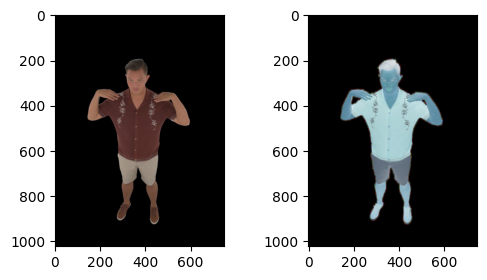

In [21]:
fid = parser.frame_ids[random.choice(list(range(len(parser.frame_ids))))]
# cid = parser.camera_ids[random.choice(list(range(len(parser.camera_ids))))]
cid = parser.camera_ids[6]
print(fid, cid)
image = parser.load_image(fid, cid)
mask = parser.load_mask(fid, cid)
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(image)
plt.subplot(122)
plt.imshow(image * mask[..., None])
plt.show()

dict_keys(['rest_verts', 'rest_joints', 'rest_tfs_bone', 'verts', 'joints', 'tf_bones', 'params'])
rest_verts (6890, 3)
rest_joints (24, 3)
rest_tfs_bone (24, 4, 4)
verts (6890, 3)
joints (24, 3)
tf_bones (24, 4, 4)
params (10,)
(3, 3) (4, 4)


<Figure size 300x410.442 with 0 Axes>

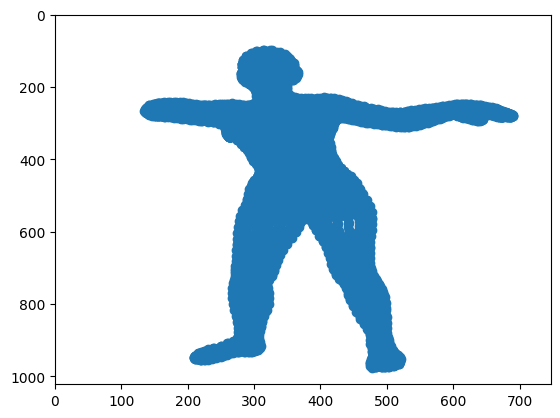

In [51]:
pose = parser.load_meta_data(fid)
print(pose.keys())
for k, v in pose.items():
    print(k, v.shape)
K, w2c = parser.cameras["K"][cid], parser.cameras["w2c"][cid]
# c2w = np.array(
# [[-1., 0., 0., 0.45],
#  [ 0., -1., 0., 0.4],
#  [ 0., 0., 1., -3.1],
#  [ 0., 0., 0., 1.]]
# ).reshape(4, 4)
# w2c = np.linalg.inv(c2w)
c2w = np.array(
        [[-1., 0., 0., 0.489624 - 0.5],
        [0., -1., 0., 0.53694844 + 0.4],
        [0., 0., 1., -3.96953058 + 1.8],
        [0., 0., 0., 1.]]
    
    # [[-1., 0., 0., 0.48962471],
    #     [0., -1., 0., 0.53694844],
    #     [0., 0., 1., -3.96953058],
    #     [0., 0., 0., 1.]]
    
# [[-1., 0., 0., 0.4],
 # [ 0., -1., 0., 0.8],
 # [ 0., 0., 1., -3.1],
 # [ 0., 0., 0., 1.]]
).reshape(4, 4)
w2c = np.linalg.inv(c2w) 
H, W = parser.cameras["heights"][cid], parser.cameras["widths"][cid]
print(K.shape, w2c.shape)

verts = pose["verts"]
homo_verts = np.concatenate([
    verts, np.ones_like(verts[:, :1])
], axis=-1)
homo_verts = (w2c @ homo_verts.T).T
homo_c_verts = homo_verts[:, :3] / homo_verts[:, 3:]
homo_proj = (K @ homo_c_verts.T).T
homo_proj = homo_proj[:, :2] / homo_proj[:, 2:]

# Matplotlib
plt.figure(figsize=(3, 3 * H / W))
fig, ax = plt.subplots()
plt.scatter(homo_proj[:, 0], homo_proj[:, 1])

# Create a Rectangle patch
# import matplotlib.patches as patches
# rect = patches.Rectangle((0, 0), W, H, linewidth=1, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
plt.xlim(0, W) 
plt.ylim(H, 0)
# plt.xlim(0, max(W, H))
# plt.ylim(0, max(W, H))
plt.show()

In [8]:
"w2c", w2c

('w2c',
 array([[-1.        , -0.        , -0.        ,  0.48962471],
        [-0.        , -1.        , -0.        ,  0.53694844],
        [ 0.        ,  0.        ,  1.        ,  3.96953058],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [9]:
"c2w", np.linalg.inv(w2c)

('c2w',
 array([[-1.        , -0.        , -0.        ,  0.48962471],
        [-0.        , -1.        , -0.        ,  0.53694844],
        [ 0.        ,  0.        ,  1.        , -3.96953058],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [10]:
verts.max(axis=0), verts.min(axis=0), verts.mean(axis=0)

(array([ 0.85068464,  1.2195089 , -0.89139646], dtype=float32),
 array([ 0.10059693, -0.4201569 , -1.294787  ], dtype=float32),
 array([ 0.46678594,  0.5944454 , -1.0765995 ], dtype=float32))

In [11]:
# from tava.datasets import zju_parser 
# root_fp = "/home/guandao/tava/data/zju"
# parser = zju_parser.SubjectParser(subject_id=313, root_fp=root_fp)
# fid = parser.frame_ids[random.choice(list(range(len(parser.frame_ids))))]
# pose = parser.load_meta_data(fid)
# verts = pose["verts"]
# verts.max(), verts.min()

# Test Pose

In [32]:
# Load vertices
root_fp = "/home/guandao/tava/data/actorhq_dataset"
parser = humanrf_parser.SubjectParser(
    subject_id=subject_id, root_fp=root_fp, post_fix=post_fix)
fid = parser.frame_ids[random.choice(list(range(len(parser.frame_ids))))]
cid = parser.camera_ids[random.choice(list(range(len(parser.camera_ids))))]
meta_data = pose = parser.load_meta_data(fid)
print(pose.keys())
for k, v in pose.items():
    print(k, v.shape)
K, w2c = parser.cameras["K"][cid], parser.cameras["w2c"][cid]
H, W = parser.cameras["heights"][cid], parser.cameras["widths"][cid]
print(K.shape, w2c.shape)


# Tranforms
from tava.utils.structures import Bones 
# load canonical meta info.
rest_matrixs = meta_data["rest_tfs_bone"][1:]  # [23, 4, 4]
rest_tails = meta_data["rest_joints"][
    [
        parser.JOINT_NAMES.index(tail_name)
        for _, tail_name in parser.BONE_NAMES
    ]
]  # [23, 3]
rest_heads = meta_data["rest_joints"][
    [
        parser.JOINT_NAMES.index(head_name)
        for head_name, _ in parser.BONE_NAMES
    ]
]  # [23, 3]
dtype = torch.float32
bones_rest = Bones(
    heads=torch.from_numpy(rest_heads).to(dtype),
    tails=torch.from_numpy(rest_tails).to(dtype),
    transforms=torch.from_numpy(rest_matrixs).to(dtype),
)  # real bones [23,]

# load view space meta info.
pose_matrixs = meta_data["tf_bones"][1:]  # [N, 23, 4, 4]
pose_heads = meta_data["joints"][
    [
        parser.JOINT_NAMES.index(head_name)
        for head_name, _ in parser.BONE_NAMES
    ],
]  # [N, 23, 3]
pose_tails = meta_data["joints"][
    [
        parser.JOINT_NAMES.index(tail_name)
        for _, tail_name in parser.BONE_NAMES
    ],
]  # [N, 23, 3]
bones_posed = Bones(
    heads=torch.from_numpy(pose_heads).to(dtype),
    tails=torch.from_numpy(pose_tails).to(dtype),
    transforms=torch.from_numpy(pose_matrixs).to(dtype),
)
print(bones_rest.transforms.shape, bones_posed.transforms.shape)
transforms = bones_rest.transforms @ bones_posed.transforms.inverse()
print(transforms.shape)

# Posed vertices
from tava.utils.knn import knn_gather
from tava.utils.bone import closest_distance_to_points 
posed_verts = torch.from_numpy(pose["verts"])
n_init = posed_verts.shape[0]
dists = closest_distance_to_points(bones_posed, posed_verts)  # [B, N, n_bones]
# select the k nearest
knn = torch.topk(dists, 1, dim=-1, largest=False)
knn_idxs = knn.indices  # [B, N, n_init]
# Gather the knn transforms
transforms = knn_gather(
    transforms.reshape(1, -1, 4 * 4), knn_idxs.reshape(1, -1, n_init)
)[0, 0].reshape(-1, 4, 4)
print(transforms.shape)
print(posed_verts.shape)
unposed_verts = torch.bmm(
    transforms[:, :3, :3], posed_verts[..., None]
)
print(unposed_verts.shape, transforms[:, :3, 3:].shape)
unposed_verts = unposed_verts + transforms[:, :3, 3:]
unposed_verts = unposed_verts[:, :, 0]
print(unposed_verts.shape)

from tava.utils.bone import get_end_points
p = mp.plot(
    posed_verts.detach().cpu().numpy(), 
    shading={"point_size": 0.05},
    return_plot=True)
heads, tails = get_end_points(bones_posed)
heads = heads.detach().cpu().numpy()
tails = tails.detach().cpu().numpy()
nbones = heads.shape[0]
p.add_edges(
    np.concatenate([heads, tails], axis=0), 
    np.array([[i, i + nbones] for i in range(nbones)]), 
    shading={"line_color": "blue", "point_size": 0.25, "line_width": 2.5}
)

    
# mp.plot(
#     unposed_verts.detach().cpu().numpy(), 
#     shading={"point_size": 0.25})


dict_keys(['rest_verts', 'rest_joints', 'rest_tfs_bone', 'verts', 'joints', 'tf_bones', 'params'])
rest_verts (6890, 3)
rest_joints (24, 3)
rest_tfs_bone (24, 4, 4)
verts (6890, 3)
joints (24, 3)
tf_bones (24, 4, 4)
params (10,)
(3, 3) (4, 4)
torch.Size([23, 4, 4]) torch.Size([23, 4, 4])
torch.Size([23, 4, 4])
torch.Size([6890, 4, 4])
torch.Size([6890, 3])
torch.Size([6890, 3, 1]) torch.Size([6890, 3, 1])
torch.Size([6890, 3])


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.036597…

1

In [13]:
# # Load vertices
# root_fp = "/home/guandao/tava/data/zju"
# parser = zju_parser.SubjectParser(subject_id=313, root_fp=root_fp)
# fid = parser.frame_ids[random.choice(list(range(len(parser.frame_ids))))]
# cid = parser.camera_ids[random.choice(list(range(len(parser.camera_ids))))]
# meta_data = pose = parser.load_meta_data(fid)
# print(pose.keys())
# 
# 
# # Tranforms
# from tava.utils.structures import Bones 
# # load canonical meta info.
# rest_matrixs = meta_data["rest_tfs_bone"][1:]  # [23, 4, 4]
# rest_tails = meta_data["rest_joints"][
#     [
#         parser.JOINT_NAMES.index(tail_name)
#         for _, tail_name in parser.BONE_NAMES
#     ]
# ]  # [23, 3]
# dtype = torch.float32
# bones_rest = Bones(
#     heads=None,
#     tails=torch.from_numpy(rest_tails).to(dtype),
#     transforms=torch.from_numpy(rest_matrixs).to(dtype),
# )  # real bones [23,]
# 
# # load view space meta info.
# pose_matrixs = meta_data["tf_bones"][1:]  # [N, 23, 4, 4]
# pose_tails = meta_data["joints"][
#     [
#         parser.JOINT_NAMES.index(tail_name)
#         for _, tail_name in parser.BONE_NAMES
#     ],
# ]  # [N, 23, 3]
# bones_posed = Bones(
#     heads=None,
#     tails=torch.from_numpy(pose_tails).to(dtype),
#     transforms=torch.from_numpy(pose_matrixs).to(dtype),
# )
# print(bones_rest.transforms.shape, bones_posed.transforms.shape)
# transforms = bones_rest.transforms @ bones_posed.transforms.inverse()
# print(transforms.shape)
# 
# # Posed vertices
# from tava.utils.knn import knn_gather
# from tava.utils.bone import closest_distance_to_points 
# posed_verts = torch.from_numpy(pose["verts"])
# n_init = posed_verts.shape[0]
# dists = closest_distance_to_points(bones_posed, posed_verts)  # [B, N, n_bones]
# # select the k nearest
# knn = torch.topk(dists, 1, dim=-1, largest=False)
# knn_idxs = knn.indices  # [B, N, n_init]
# # Gather the knn transforms
# transforms = knn_gather(
#     transforms.reshape(1, -1, 4 * 4), knn_idxs.reshape(1, -1, n_init)
# )[0, 0].reshape(-1, 4, 4)
# print(transforms.shape)
# print(posed_verts.shape)
# unposed_verts = torch.bmm(
#     transforms[:, :3, :3], posed_verts[..., None]
# )
# print(unposed_verts.shape, transforms[:, :3, 3:].shape)
# unposed_verts = unposed_verts + transforms[:, :3, 3:]
# unposed_verts = unposed_verts[:, :, 0]
# print(unposed_verts.shape)
# 
# mp.plot(
#     posed_verts.detach().cpu().numpy(), 
#     shading={"point_size": 0.25})
# # mp.plot(
# #     unposed_verts.detach().cpu().numpy(), 
# #     shading={"point_size": 0.25})
# 

In [17]:
import numpy as np 
pose_data = np.load("/media/data2/cyanzhao/actorhq_dataset/Actor03/Sequence1/4x/tava/pose_data.npy", allow_pickle=True).item()
pose_data.keys()

dict_keys(['lbs_weights', 'rest_verts', 'rest_joints', 'rest_tfs_bone', 'verts', 'joints', 'tf_bones', 'params'])

In [18]:
pose_data_qual = np.load(
    "/media/data2/cyanzhao/actorhq_dataset/Actor03_qual/Sequence1/4x/tava/pose_data.npy", allow_pickle=True).item()
pose_data_qual.keys()

dict_keys(['lbs_weights', 'rest_verts', 'rest_joints', 'rest_tfs_bone', 'verts', 'joints', 'tf_bones', 'params'])

In [19]:
verts_1 = pose_data["verts"][0].reshape(-1, 3)
verts_2 = pose_data_qual["verts"][0].reshape(-1, 3)
p = mp.plot(verts_1, shading={"point_color": "red"}, return_plot=True)
p.add_points(verts_2, shading={"point_color": "blue"})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0392666…

1